# 뉴스 요약봇 만들기

In [2]:
from importlib.metadata import version
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup 

import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import summa

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3.6.5
2.6.0
1.3.3
1.2.0


https://github.com/sunnysai12345/News_Summary

In [22]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [23]:
data.sample(10)

,headlines,text
81665,SC asks Tamil Nadu govt not to force farmers t...,The Supreme Court asked the Tamil Nadu governm...
80269,Victoria Beckham slammed for claiming that she...,Victoria Beckham has been slammed by Land Rove...
82182,Jet Airways shares jump over reports of stake ...,Shares of Jet Airways on Monday surged over 3%...
97170,75% forum engagement on Startup IndiaÃ¢ÂÂs o...,Startup IndiaÃ¢ÂÂs online learning and devel...
79522,Trailer of Amole Gupte's directorial 'Sniff' r...,The trailer of Amole Gupte's upcoming director...
45317,"Man steals women's undergarments in Noida, arr...",A 25-year-old man was detained by the police o...
31463,Alaskans mistakenly receive tsunami warning,Alaskans mistakenly received a tsunami warning...
57288,What is the religious significance of Jerusalem?,"Jerusalem, central to the Israel-Palestine con..."
21423,"TRS leader hoists party flag, not Tricolour on...",A local leader of Telangana Rashtra Samithi (T...
86912,Arsenal's ÃÂzilÃ¢ÂÂ tweets about Ranveer S...,Arsenal footballer Mesut ÃÂzil retweeted Bol...


## 데이터 전처리(추상적 요약)

In [24]:
data.shape

(98401, 2)

### 중복 데이터 확인

In [25]:
print("headlines에서 유니크한 샘플 수: ",data['headlines'].nunique())
print("text에서 유니크한 샘플 수: ",data['text'].nunique())

headlines에서 유니크한 샘플 수:  98280
text에서 유니크한 샘플 수:  98360


=> text에서 중복데이터가 존재한다. drop으로 제거

In [26]:
data.drop_duplicates(subset=["text"], inplace=True)
data.shape

(98360, 2)

### 결측치 확인

In [27]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

=> 결측치 없음

### 텍스트 정규화 & stopwords 제거

In [28]:
# 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [29]:
# stopwords 사전
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

In [30]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

전처리 함수로 전처리

In [31]:
def apply_preprocessing(df_column,remove_stopwords=True):
    clean_data = []
    for sentence in df_column:
        clean_sentence = preprocess_sentence(sentence, remove_stopwords)
        clean_data.append(clean_sentence)
    return clean_data

In [32]:
clean_headlines = apply_preprocessing(data['headlines'], remove_stopwords=False)
clean_text = apply_preprocessing(data['text'])

In [33]:
# 전처리 확인
print("headlines 확인", clean_headlines[:5])
print("text 확인", clean_text[:5])

headlines 확인 ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']
text 확인 ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi

In [34]:
data['headlines'] = clean_headlines
data['text'] = clean_text

In [35]:
# ''(빈 문자열)를 Null로 변환
data.replace('', np.nan, inplace=True)

In [36]:
# 데이터 전처리에 따른 결측치가 있나 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [37]:
display(data.head())
data.shape

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...


(98360, 2)

In [38]:
# 전처리 완료한 df 저장
data.to_csv("news_preprocessed.csv", index=False)

In [4]:
data = pd.read_csv("news_preprocessed.csv")
display(data.head())
data.shape

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...


(98360, 2)

### 문장의 길이 분포 분석

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


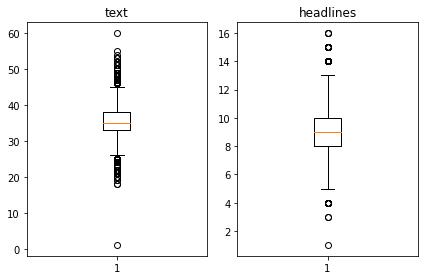

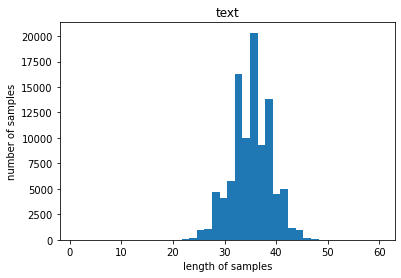

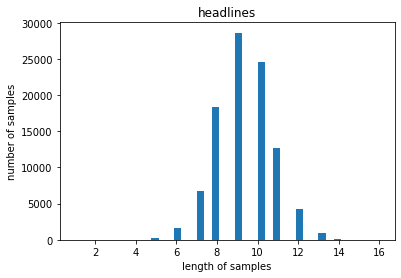

In [5]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [6]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [7]:
text_max_len = 40
headlines_max_len = 10

In [8]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


text가 40이하 이면서 headlines 10이하인 샘플만 사용

In [9]:
data = data[
    data.apply(
        lambda x: (
            len(x['text'].split()) <= text_max_len and 
            len(x['headlines'].split()) <= headlines_max_len
        ), 
        axis=1
    )
]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 74102


### headlines에 시작 토큰과 종료 토큰 추가

In [10]:
data.loc[:,'decoder_input'] = data['headlines'].apply(
    lambda x : 'sostoken '+ x)
data.loc[:,'decoder_target'] = data['headlines'].apply(
    lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


### numpy 타입으로 변환

In [11]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [12]:
encoder_input[0]

'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'

In [13]:
decoder_input[0]

'sostoken new zealand end rohit sharma led india match winning streak'

In [14]:
decoder_target[0]

'new zealand end rohit sharma led india match winning streak eostoken'

### data shuffle

In [15]:
# 셔플된 인덱스를 생성해서, 데이터를 셔플
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[58750  3393 61168 ... 31619  6391 19635]


In [16]:
# 데이터를 셔플
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

### test set 나누기

In [17]:
n_of_val = int(len(encoder_input)*0.2)
print("전체 데이터의 수: ", len(encoder_input))
print('테스트 데이터의 수 :', n_of_val)

전체 데이터의 수:  74102
테스트 데이터의 수 : 14820


In [18]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


### 단어 집합 생성

encoder_input에 대해 수행  
기본 토크나이저를 생성해서, 전체 통계를 확인 후, 빈도수 높은 단어들만 단어 집합을 생성

In [19]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [20]:
# 확인
# [obj for obj in dir(src_tokenizer) if not obj.startswith("_")]

In [21]:
# 확인
# src_tokenizer.word_index

In [22]:
def get_vocab_summary(threshold, tokenizer):
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :', total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [23]:
get_vocab_summary(11,src_tokenizer)

단어 집합(vocabulary)의 크기 : 61461
등장 빈도가 10번 이하인 희귀 단어의 수: 46385
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 15076
단어 집합에서 희귀 단어의 비율: 75.4706236475163
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.906382903982978


10번 이하 희귀 단어 등장 비율이 5.9% 정도이다.  
10번 이하 등장하는 단어를 제외하고,  
단어 집합의 크기를 15000으로 제한

In [24]:
src_vocab = 15000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 15,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [25]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[8, 1, 855, 1451, 190, 16, 1003, 266, 2, 4, 5022, 1451, 175, 883, 119, 855, 1052, 59, 2736, 14, 2539, 328, 201, 1573, 2279, 1145, 1, 140, 5022, 1451, 331, 359, 115], [12, 1017, 1623, 314, 1338, 2553, 482, 8466, 50, 1, 129, 2156, 2156, 305, 706, 5974, 1117, 1792, 14346, 6751, 5974, 3098, 2475, 33, 1085, 994, 70, 4, 915, 825, 4158, 342, 26, 165, 1], [45, 97, 1166, 372, 83, 1, 140, 4159, 1164, 1041, 30, 23, 2141, 2195, 1793, 226, 198, 67, 2172, 63, 8, 215, 227, 19, 3041, 1333, 627, 560, 72, 8, 4]]


headlines에 대해 수행   
headlines에 대해서도 기본 토크나이저를 생성해서 통계 확인후, 빈도 높은 단어들만 단어 집합 생성  

In [26]:
tar_tokenizer = Tokenizer() 
tar_tokenizer.fit_on_texts(decoder_input_train)

In [27]:
get_vocab_summary(6,tar_tokenizer)

단어 집합(vocabulary)의 크기 : 27295
등장 빈도가 5번 이하인 희귀 단어의 수: 18244
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9051
단어 집합에서 희귀 단어의 비율: 66.84008060084264
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.978804479299453


5번 이하 희귀 단어 등장 비율이 약 6% 정도이다.  
5번 이하 등장하는 단어를 제외하고,  
단어 집합의 크기를 9000으로 제한

In [28]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1118, 2342, 144, 40, 4146, 61, 542, 35], [1, 352, 4872, 29, 196, 26, 2843], [1, 1844, 437, 2929, 147, 1752, 5724, 894, 379], [1, 194, 3122, 1181, 120, 419, 8, 339, 427, 78], [1, 21, 270, 6992, 3, 1574, 30, 42]]
target
decoder  [[1118, 2342, 144, 40, 4146, 61, 542, 35, 2], [352, 4872, 29, 196, 26, 2843, 2], [1844, 437, 2929, 147, 1752, 5724, 894, 379, 2], [194, 3122, 1181, 120, 419, 8, 339, 427, 78, 2], [21, 270, 6992, 3, 1574, 30, 42, 2]]


희귀 단어를 제거함으로써 headlines에 결측치가 발생할 수도 있다.  
이를 확인

In [29]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


패딩하기

In [30]:
# encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
# encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
# decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
# decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
# decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
# decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

In [31]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='pre')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='pre')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='pre')

## 모델 설계

In [32]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)



In [33]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [34]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1920000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [35]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 26s 82ms/step - loss: 6.2429 - val_loss: 5.8505
Epoch 2/50
232/232 [==============================] - 18s 77ms/step - loss: 5.8897 - val_loss: 5.8526
Epoch 3/50
232/232 [==============================] - 18s 79ms/step - loss: 5.7382 - val_loss: 5.5578
Epoch 4/50
232/232 [==============================] - 19s 80ms/step - loss: 5.4813 - val_loss: 5.3207
Epoch 5/50
232/232 [==============================] - 19s 81ms/step - loss: 5.2271 - val_loss: 5.0889
Epoch 6/50
232/232 [==============================] - 19s 82ms/step - loss: 4.9958 - val_loss: 4.9217
Epoch 7/50
232/232 [==============================] - 19s 83ms/step - loss: 4.7900 - val_loss: 4.8101
Epoch 8/50
232/232 [==============================] - 19s 84ms/step - loss: 4.6063 - val_loss: 4.6606
Epoch 9/50
232/232 [==============================] - 20s 84ms/step - loss: 4.4381 - val_loss: 4.5553
Epoch 10/50
232/232 [==============================] - 20s 85ms/step - loss: 4.284

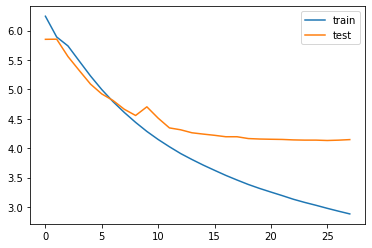

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

28 에폭 이후, val_loss가 줄지 않아, early stop 하였음.

인덱스 -> 텍스트 복원을 위한 사전 준비

In [37]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

### 추론단계에 사용하는 seq2seq 모델 설계

In [38]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])



In [39]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])



In [40]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence


In [41]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if i not in [0, 1, 2]:
            temp = temp + tar_index_to_word[i]+' '
    return temp


In [62]:
# for i in range(50, 100):
for i in range(50, 55):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : indian space research organisation maiden mission mars orbiter mission completed earth days orbit monday notably mom designated last six months original isro mission launched november pslv entered martian orbit september 
실제 요약 : isro mars mission completes earth days 
예측 요약 :  nasa to launch st ever space station in space


원문 : actress sridevi said point discussing rejected role queen eventually portrayed actress krishnan ss rajamouli film series baahubali reported sridevi first choice play role however makers cast reportedly demanded crore play part 
실제 요약 : no point in talking about why rejected baahubali sridevi 
예측 요약 :  sridevi to be used for sridevi in film report


원문 : manipur civil rights activist chanu sharmila wednesday filed marriage papers long time partner coutinho duo filed papers sub registrar office rented house however inter religious marriage cannot happen immediately would registered special marriage act requires window days 
실제 요약 : sharmila partner file mar

## Summa를 이용해서 추출적 요약

In [63]:
from summa.summarizer import summarize

In [64]:
# for i in range(50, 100):
for i in range(50,55):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("추출적 요약 :",summarize(seq2text(encoder_input_test[i]),words=20, split=False))
    print("\n")

원문 : indian space research organisation maiden mission mars orbiter mission completed earth days orbit monday notably mom designated last six months original isro mission launched november pslv entered martian orbit september 
실제 요약 : isro mars mission completes earth days 
예측 요약 :  nasa to launch st ever space station in space
추출적 요약 : 


원문 : actress sridevi said point discussing rejected role queen eventually portrayed actress krishnan ss rajamouli film series baahubali reported sridevi first choice play role however makers cast reportedly demanded crore play part 
실제 요약 : no point in talking about why rejected baahubali sridevi 
예측 요약 :  sridevi to be used for sridevi in film report
추출적 요약 : 


원문 : manipur civil rights activist chanu sharmila wednesday filed marriage papers long time partner coutinho duo filed papers sub registrar office rented house however inter religious marriage cannot happen immediately would registered special marriage act requires window days 
실제 요약 : sharm

=> 원문이 너무 짧아서 추출적 요약이 잘 수행되지 않았다.

In [65]:
# 커스텀 함수를 만들어 추출적 요약 시도
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def custom_extractive_summary(text, top_n_words=10):
    # 문장 분할
    sentences = sent_tokenize(text)
    if not sentences:
        return ""

    # 각 문장 간 유사도 계산
    # TF-IDF 벡터화 및 유사도 계산
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
    sim_matrix = cosine_similarity(tfidf_matrix) # 코사인 유사도 계산
    sentence_scores = sim_matrix.sum(axis=1) # 다른 문장들과의 유사성 점수가 높은 문장이 중심문장이라고 판단.

    # 가장 중심적인 문장 하나 선택
    best_index = np.argmax(sentence_scores)
    best_sentence = sentences[best_index]

    # 선택된 문장에서 단어별 중요도 계산
    words = word_tokenize(best_sentence)
    word_scores = {}

    # 해당 문장만 벡터화해서 단어 중요도 추출
    tfidf = TfidfVectorizer()
    tfidf.fit([best_sentence])
    feature_names = tfidf.get_feature_names_out()
    tfidf_scores = tfidf.transform([best_sentence]).toarray()[0]

    for word, score in zip(feature_names, tfidf_scores):
        word_scores[word] = score

    # 단어 정렬 후 상위 N개 선택
    ranked_words = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)
    top_words = [word for word, _ in ranked_words[:top_n_words]]

    return ' '.join(top_words)


[nltk_data] Downloading package punkt to /aiffel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [66]:
custom_extractive_summary(seq2text(encoder_input_test[50]))

'mission orbit completed days designated earth entered indian isro last'

### 추상적 요약과 비교

In [67]:
texts = []
headlines = []
predictions = []
extractions = []
for i in range(50, 100):
    if i < 55:
        print("원문 :", seq2text(encoder_input_test[i]))
        print("실제 요약 :", seq2summary(decoder_input_test[i]))
        print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
        print("추출적 요약 :",custom_extractive_summary(seq2text(encoder_input_test[i])))
        print("\n")
    texts.append(seq2text(encoder_input_test[i]))
    headlines.append(seq2summary(decoder_input_test[i]))
    predictions.append(decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    extractions.append(custom_extractive_summary(seq2text(encoder_input_test[i])))

원문 : indian space research organisation maiden mission mars orbiter mission completed earth days orbit monday notably mom designated last six months original isro mission launched november pslv entered martian orbit september 
실제 요약 : isro mars mission completes earth days 
예측 요약 :  nasa to launch st ever space station in space
추출적 요약 : mission orbit completed days designated earth entered indian isro last


원문 : actress sridevi said point discussing rejected role queen eventually portrayed actress krishnan ss rajamouli film series baahubali reported sridevi first choice play role however makers cast reportedly demanded crore play part 
실제 요약 : no point in talking about why rejected baahubali sridevi 
예측 요약 :  sridevi to be used for sridevi in film report
추출적 요약 : actress play role sridevi baahubali cast choice crore demanded discussing


원문 : manipur civil rights activist chanu sharmila wednesday filed marriage papers long time partner coutinho duo filed papers sub registrar office re

In [68]:
result_df = pd.DataFrame(data={"text":texts, "headline":headlines,"prediction":predictions, "extraction": extractions})
result_df.head()

,text,headline,prediction,extraction
0,indian space research organisation maiden miss...,isro mars mission completes earth days,nasa to launch st ever space station in space,mission orbit completed days designated earth ...
1,actress sridevi said point discussing rejected...,no point in talking about why rejected baahuba...,sridevi to be used for sridevi in film report,actress play role sridevi baahubali cast choic...
2,manipur civil rights activist chanu sharmila w...,sharmila partner file marriage papers,officer who accused of sexual harassment in j...,marriage filed papers act activist cannot chan...
3,union environment ministry approved proposal e...,environment ministry approves delhi airport ex...,govt approves air india air most expensive ai...,expansion airport annum million per approved c...
4,bjp appointed former congress minister party a...,bjp leaders resign as ex cong minister selecte...,bjp mla quits party for bjp leaders in taka,bjp appointed chief congress leaders local par...


In [69]:
# 문법 완성도 평가
from transformers import pipeline

grammar_checker = pipeline("text-classification", model="textattack/bert-base-uncased-CoLA")


In [70]:
result_df['prediction'].apply(grammar_checker)[:5]

0    [{'label': 'LABEL_0', 'score': 0.9659214019775...
1    [{'label': 'LABEL_0', 'score': 0.9450816512107...
2    [{'label': 'LABEL_0', 'score': 0.9315298795700...
3    [{'label': 'LABEL_0', 'score': 0.8901442289352...
4    [{'label': 'LABEL_0', 'score': 0.8668698668479...
Name: prediction, dtype: object

LABEL_0 -> 문법적으로 부적절함,   
LABEL_1 -> 문법적으로 적절함  
score -> 신뢰도

In [71]:
result_df['prediction_grammar'] = result_df['prediction'].apply(lambda x: grammar_checker(x)[0]['label'].split("_")[1])
result_df['extraction_grammar'] = result_df['extraction'].apply(lambda x: grammar_checker(x)[0]['label'].split("_")[1])

In [72]:
result_df.head()

,text,headline,prediction,extraction,prediction_grammar,extraction_grammar
0,indian space research organisation maiden miss...,isro mars mission completes earth days,nasa to launch st ever space station in space,mission orbit completed days designated earth ...,0,0
1,actress sridevi said point discussing rejected...,no point in talking about why rejected baahuba...,sridevi to be used for sridevi in film report,actress play role sridevi baahubali cast choic...,0,0
2,manipur civil rights activist chanu sharmila w...,sharmila partner file marriage papers,officer who accused of sexual harassment in j...,marriage filed papers act activist cannot chan...,0,0
3,union environment ministry approved proposal e...,environment ministry approves delhi airport ex...,govt approves air india air most expensive ai...,expansion airport annum million per approved c...,0,0
4,bjp appointed former congress minister party a...,bjp leaders resign as ex cong minister selecte...,bjp mla quits party for bjp leaders in taka,bjp appointed chief congress leaders local par...,0,0


In [73]:
print("추상적 예측 요약의 문법 완성도 점수: ",result_df['prediction_grammar'].astype('int').sum())
print("추출적 요약의 문법 완성도 점수: ",result_df['extraction_grammar'].astype('int').sum())

추상적 예측 요약의 문법 완성도 점수:  6
추출적 요약의 문법 완성도 점수:  3


=> bert모델을 사용해서, 문법 완성도를 평가했을 때, 50문장 중 추상적 요약은 6문장이 적합으로 판단되었고, 추출적 요약은 3문장이 적합 판단되었다.  

In [74]:
print("추상적 예측 요약의 문법 완성도 점수: ",result_df['prediction_grammar'].astype('int').mean())
print("추출적 요약의 문법 완성도 점수: ",result_df['extraction_grammar'].astype('int').mean())

추상적 예측 요약의 문법 완성도 점수:  0.12
추출적 요약의 문법 완성도 점수:  0.06


In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf 벡터화하여 빈도수 기반으로 상위 10개의 단어를 추출
def extract_keywords(text, top_k=10):
    vec = TfidfVectorizer(stop_words='english')  # 한국어면 별도 불용어 처리 필요
    tfidf = vec.fit_transform([text])
    scores = tfidf.toarray()[0]
    word_index = {word: idx for idx, word in enumerate(vec.get_feature_names_out())}
    sorted_words = sorted(word_index.items(), key=lambda x: scores[x[1]], reverse=True)
    return [w for w, _ in sorted_words[:top_k]]

# 텍스트 기반 빈도가 높은 단어 10개가 추출한 문장에 얼마나 있는지 평가
def keyword_coverage_score(text, extraction, top_k=10):
    keywords = extract_keywords(text, top_k)
    included = [kw for kw in keywords if kw in extraction]
    score = len(included) / len(keywords)
    return {
        "핵심단어": keywords,
        "포함된 단어": included,
        "포함률": round(score, 2)
    }


In [76]:
keyword_coverage_score(result_df['text'][0],result_df['prediction'][0])

{'핵심단어': ['mission',
  'orbit',
  'completed',
  'days',
  'designated',
  'earth',
  'entered',
  'indian',
  'isro',
  'launched'],
 '포함된 단어': [],
 '포함률': 0.0}

In [77]:
keyword_coverage_score(result_df['text'][0],result_df['extraction'][0])

{'핵심단어': ['mission',
  'orbit',
  'completed',
  'days',
  'designated',
  'earth',
  'entered',
  'indian',
  'isro',
  'launched'],
 '포함된 단어': ['mission',
  'orbit',
  'completed',
  'days',
  'designated',
  'earth',
  'entered',
  'indian',
  'isro'],
 '포함률': 0.9}

In [78]:
result_df['pred_keyword_ratio']=result_df[['text','prediction']].apply(lambda row: keyword_coverage_score(row['text'], row['prediction'])['포함률'],
    axis=1)
result_df['extr_keyword_ratio']=result_df[['text','extraction']].apply(lambda row: keyword_coverage_score(row['text'], row['extraction'])['포함률'],
    axis=1)


In [79]:
result_df.head()

,text,headline,prediction,extraction,prediction_grammar,extraction_grammar,pred_keyword_ratio,extr_keyword_ratio
0,indian space research organisation maiden miss...,isro mars mission completes earth days,nasa to launch st ever space station in space,mission orbit completed days designated earth ...,0,0,0.0,0.9
1,actress sridevi said point discussing rejected...,no point in talking about why rejected baahuba...,sridevi to be used for sridevi in film report,actress play role sridevi baahubali cast choic...,0,0,0.1,1.0
2,manipur civil rights activist chanu sharmila w...,sharmila partner file marriage papers,officer who accused of sexual harassment in j...,marriage filed papers act activist cannot chan...,0,0,0.0,0.9
3,union environment ministry approved proposal e...,environment ministry approves delhi airport ex...,govt approves air india air most expensive ai...,expansion airport annum million per approved c...,0,0,0.0,0.9
4,bjp appointed former congress minister party a...,bjp leaders resign as ex cong minister selecte...,bjp mla quits party for bjp leaders in taka,bjp appointed chief congress leaders local par...,0,0,0.3,1.0


In [81]:
print("추상적 예측 요약의 핵심단어 포함 정도 점수", result_df['pred_keyword_ratio'].astype(float).mean())
print("추출적 요약의 핵심단어 포함 정도 점수",result_df['extr_keyword_ratio'].astype(float).mean())

추상적 예측 요약의 핵심단어 포함 정도 점수 0.1
추출적 요약의 핵심단어 포함 정도 점수 0.93


=> (샘플 50개만 확인했으므로 일반화하기는 어렵지만,) 추출한 50개의 샘플을 확인했을 때,    
모델을 사용한 추상적 요약의 문법 완성도가 조금 더 높은 것을 확인하였다.   
=> 핵심단어 포함 정도를 확인했을 때는 추출적 요약한 문장이 더 많은 핵심단어를 포함한 것을 확인할 수 있었다. 

# 회고 

언어를 벡터화하는 과정이 매우 신기했다.  
seq2seq 모델의 구조에 대해서는 아직 어렴풋하게만 이해하고 있지만, 앞으로 더 많이 실습해보며 익숙해지고 싶다.  
트랜스포머 모델과 구조에 대해서도 더 공부를 해야겠다고 느꼈다.  
평가 지표가 없는 문제에 대해서, 어떻게 모델을 평가해야 할지 고민을 해보는 계기가 되었다.  
문장의 문법 완성도를 평가하는 방법도 bert 모델을 사용한 것이기 때문에, 신뢰도는 다시 생각해봐야 하는 것 같다.  

# 퍼실님 피드백

BERT 기반의 text classification으로 문법의 완성도 측면을 비교한 부분과 tf-idf기반의 문장 유사도 비교 내용이 특히 좋았습니다.
- 실제 레이블과 생성한 문장간의 일치 정도를 비교한다는 측면에서 recall기반의 방식으로 비교해보신 것 같습니다.
- NLP에서 활용하는 평가 지표 중 recall 기반의 지표인 rouge score를 공부해보시면 좋을 것 같습니다. 실제 요약 결과를 확인하는데 사용하는 지표이기도 합니다. 고생하셨습니다 :)